In [4]:
import pandas as pd
import yfinance as yf

In [43]:
df = pd.read_parquet('cleaned_options_SPX.parquet')  
print(df.head())
print(df.info())
print(df.isnull().sum())
print(df.describe())
print(df.tail())

  ticker        date      exdate cp_flag  open_interest  contract_size  \
0    SPX  2018-08-31  2018-09-21       C             65            100   
1    SPX  2018-08-31  2018-09-21       C             22            100   
2    SPX  2018-08-31  2018-09-21       C             82            100   
3    SPX  2018-08-31  2018-09-21       C           1096            100   
4    SPX  2018-08-31  2018-09-21       C             11            100   

      gamma  
0  0.000020  
1  0.000030  
2  0.000016  
3  0.000039  
4  0.000048  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13569891 entries, 0 to 13569890
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   ticker         object 
 1   date           object 
 2   exdate         object 
 3   cp_flag        object 
 4   open_interest  int64  
 5   contract_size  int64  
 6   gamma          float64
dtypes: float64(1), int64(2), object(4)
memory usage: 724.7+ MB
None
ticker           0
date             

In [11]:
df['gamma_dollar'] = df['gamma'] * df['open_interest'] * df['contract_size']
daily_gamma = df.groupby(['date', 'cp_flag'])['gamma_dollar'].sum().unstack(fill_value=0)
daily_gamma['gamma_imbalance'] = daily_gamma.get('C', 0) - daily_gamma.get('P', 0)
daily_gamma

cp_flag,C,P,gamma_imbalance
date,,,
2018-08-31,1.422563e+06,8.169748e+05,605588.1614
2018-09-04,1.411791e+06,8.737941e+05,537996.8253
2018-09-05,1.370193e+06,9.527597e+05,417433.2000
2018-09-06,1.348196e+06,1.076437e+06,271759.2636
2018-09-07,1.198478e+06,1.098894e+06,99583.3045
...,...,...,...
2023-08-25,5.296957e+05,6.543857e+05,-124690.0560
2023-08-28,5.951647e+05,6.437450e+05,-48580.2544
2023-08-29,6.776825e+05,5.933855e+05,84297.0141


In [13]:
daily_gamma['percentile'] = daily_gamma['gamma_imbalance'].rank(pct=True)
daily_gamma['signal'] = 0
daily_gamma.loc[daily_gamma['percentile'] > 0.75, 'signal'] = 1
daily_gamma.loc[daily_gamma['percentile'] < 0.25, 'signal'] = -1
daily_gamma

cp_flag,C,P,gamma_imbalance,percentile,signal
date,,,,,
2018-08-31,1.422563e+06,8.169748e+05,605588.1614,0.990461,1
2018-09-04,1.411791e+06,8.737941e+05,537996.8253,0.976153,1
2018-09-05,1.370193e+06,9.527597e+05,417433.2000,0.934022,1
2018-09-06,1.348196e+06,1.076437e+06,271759.2636,0.864865,1
2018-09-07,1.198478e+06,1.098894e+06,99583.3045,0.632750,0
...,...,...,...,...,...
2023-08-25,5.296957e+05,6.543857e+05,-124690.0560,0.213831,-1
2023-08-28,5.951647e+05,6.437450e+05,-48580.2544,0.337838,0
2023-08-29,6.776825e+05,5.933855e+05,84297.0141,0.595390,0


In [37]:
spx = yf.download("^GSPC", start=daily_gamma.index.min(), end=daily_gamma.index.max(), auto_adjust=True)

spx = spx[['Close']].copy()
spx.columns = ['SPX_price']

spx.index = pd.to_datetime(spx.index)
daily_gamma.index = pd.to_datetime(daily_gamma.index)

if 'SPX_price' in daily_gamma.columns:
    daily_gamma = daily_gamma.drop(columns=['SPX_price'])
daily_gamma = daily_gamma.merge(spx, left_index=True, right_index=True, how='left')
daily_gamma['SPX_return'] = daily_gamma['SPX_price'].pct_change(fill_method=None)

daily_gamma['strategy_return'] = daily_gamma['signal'] * daily_gamma['SPX_return']

daily_gamma['cumulative_return'] = (1 + daily_gamma['strategy_return'].fillna(0)).cumprod()


[*********************100%***********************]  1 of 1 completed


In [39]:
daily_gamma

,C,P,gamma_imbalance,percentile,signal,SPX_price_x,SPX_return,strategy_return,cumulative_return,SPX_price_y,SPX_price
date,,,,,,,,,,,
2018-08-31,1.422563e+06,8.169748e+05,605588.1614,0.990461,1,2901.520020,NaN,NaN,1.000000,2901.520020,2901.520020
2018-09-04,1.411791e+06,8.737941e+05,537996.8253,0.976153,1,2896.719971,-0.001654,-0.001654,0.998346,2896.719971,2896.719971
2018-09-05,1.370193e+06,9.527597e+05,417433.2000,0.934022,1,2888.600098,-0.002803,-0.002803,0.995547,2888.600098,2888.600098
2018-09-06,1.348196e+06,1.076437e+06,271759.2636,0.864865,1,2878.050049,-0.003652,-0.003652,0.991911,2878.050049,2878.050049
2018-09-07,1.198478e+06,1.098894e+06,99583.3045,0.632750,0,2871.679932,-0.002213,-0.000000,0.991911,2871.679932,2871.679932
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-25,5.296957e+05,6.543857e+05,-124690.0560,0.213831,-1,4405.709961,0.006718,-0.006718,13.104008,4405.709961,4405.709961
2023-08-28,5.951647e+05,6.437450e+05,-48580.2544,0.337838,0,4433.310059,0.006265,0.000000,13.104008,4433.310059,4433.310059
2023-08-29,6.776825e+05,5.933855e+05,84297.0141,0.595390,0,4497.629883,0.014508,0.000000,13.104008,4497.629883,4497.629883


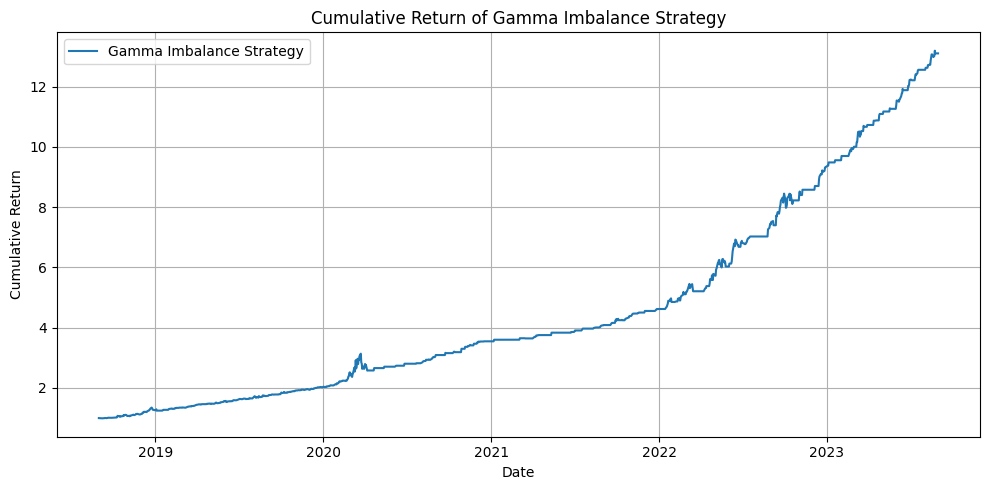

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(daily_gamma['cumulative_return'], label='Gamma Imbalance Strategy')
plt.title('Cumulative Return of Gamma Imbalance Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:

dfs = pd.read_parquet('SPY_combined_minute_data.parquet')  
print(dfs.head())
print(dfs.info())
print(dfs.isnull().sum())
print(dfs.describe())
print(dfs.tail())

                  timestamp        open        high         low       close  \
0 2018-08-31 13:30:00+00:00  289.869995  289.885010  289.790009  289.850006   
1 2018-08-31 13:31:00+00:00  289.834991  289.970001  289.820007  289.950012   
2 2018-08-31 13:32:00+00:00  289.940002  290.040009  289.920013  290.040009   
3 2018-08-31 13:33:00+00:00  290.029999  290.054993  289.950012  289.989990   
4 2018-08-31 13:34:00+00:00  289.964996  290.035004  289.950012  289.975006   

         date  year  month  day  hour  minute  
0  2018-08-31  2018      8   31    13      30  
1  2018-08-31  2018      8   31    13      31  
2  2018-08-31  2018      8   31    13      32  
3  2018-08-31  2018      8   31    13      33  
4  2018-08-31  2018      8   31    13      34  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506041 entries, 0 to 506040
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   timestamp  5060

In [178]:
df[df['open_interest'] > 0]

,ticker,date,exdate,cp_flag,open_interest,contract_size,gamma,Pt,Volume_SPY,gamma_dollar
0,SPX,2018-08-31,2018-09-21,C,65,100,0.000020,259.882141,66140800,33.784678
1,SPX,2018-08-31,2018-09-21,C,22,100,0.000030,259.882141,66140800,17.152221
2,SPX,2018-08-31,2018-09-21,C,82,100,0.000016,259.882141,66140800,34.096537
3,SPX,2018-08-31,2018-09-21,C,1096,100,0.000039,259.882141,66140800,1110.840224
4,SPX,2018-08-31,2018-09-21,C,11,100,0.000048,259.882141,66140800,13.721777
...,...,...,...,...,...,...,...,...,...,...
13569886,SPX,2023-08-31,2024-06-28,P,39,100,0.000664,438.673920,66084600,-1135.989982
13569887,SPX,2023-08-31,2024-06-28,P,2,100,0.000608,438.673920,66084600,-53.342749
13569888,SPX,2023-08-31,2024-06-28,P,2,100,0.000529,438.673920,66084600,-46.411701
13569889,SPX,2023-08-31,2024-06-28,P,18,100,0.000440,438.673920,66084600,-347.429744
